In [111]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import pymssql
from csv import DictWriter
from datetime import datetime
import yfinance as yf

from sklearn.linear_model import Ridge
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import itertools
import warnings
warnings.filterwarnings('ignore')

### Backtest - Linear Regression from class

In [112]:
#reads return from linear regression from first back test from class
rets_org = pd.read_csv("./rets_orig.csv", parse_dates=["date"], index_col="date")
rets_org.index = rets_org.index.to_period("M")

#### Fama-French factors

In [114]:
ff = pdr("F-F_Research_Data_5_Factors_2x3", "famafrench", start=2005)[0]/100

#### SP500 Returns

In [ ]:
SPY500 = yf.download('^GSPC', start="2000-01-01", end="2023-01-31")
SP500.dropna()

SPY500 = SPY500.groupby([SPY500.index.year, SPY500.index.month]).last()

# Convert the multi-level index to a DateTime index
SPY500.index = pd.to_datetime(dict(year=SPY500.index.get_level_values(0), 
                                        month=SPY500.index.get_level_values(1),
                                        day=1))

SPY500.index = SPY500.index.to_period("M")
SPY500['ret'] = (SPY500['Adj Close']/ SPY500['Adj Close'].shift(1)) -1
SPY500

#### Market and 130/30 returns

In [116]:
rets_org["mkt"] = ff["Mkt-RF"] + ff["RF"]
rets_org["rf"] = ff["RF"]
rets_org["ls"] = 1.3*rets_org["best"] - 0.3*rets_org["worst"]

In [117]:
#initializes result table
row = {}
criteria = ["best", "worst", "mkt", "ls"]
row["features"] = ["Linear_reg - roeq, bm, mom12m"]
xrets_org = rets_org[["best", "worst", "mkt", "ls"]].subtract(rets_org.rf, axis=0)

for col in criteria:
    row["ret_" + col] = [12*rets_org[col].mean()]
    
for col in criteria:
    row["std_" + col] = [np.sqrt(12)*rets_org[col].std()]

for col in criteria:
    row["sratio_" + col] = [np.sqrt(12)*xrets_org[col].mean()/xrets_org[col].std()]

row["num_feat"] = 3
    
result = pd.DataFrame(row)

### Ridge Regression - (Alpha = 0.1)

In [118]:
model = Ridge(alpha=0.1)
prepoc = PolynomialFeatures(degree=2) #preprocessing, add a polynomial term of degree two to capture non-linearity
#prepoc = StandardScaler()
qt = QuantileTransformer(output_distribution="normal") #transform data to treat outliers

In [119]:
server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" 
dfbase = "ghz"
string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + dfbase
conn = create_engine(string).connect()

In [120]:
df = pd.read_sql(
    """
    select ticker, date, ret, mve, acc, agr, beta, bm, ep, gma, idiovol, lev, mom12m, mom1m, 
        operprof, roeq, roic, roaq, retvol, saleinv, currat
    from data
    where date>='2000-01'
    order by date, ticker
    """, 
    conn
)
df = df.dropna()
conn.close()

df = df.set_index(["date", "ticker"])

In [121]:
#Rank the stocks by size
df["size_rnk"] = df.groupby('date').mve.rank(ascending=False)

In [122]:
#drop largest stocks from original table
df = df[df["size_rnk"]>500] 
df.head(10)

ret        mve       acc       agr      beta        bm  \
date    ticker                                                                
2000-01 AAC     0.056338  12.072728 -0.144323 -0.139600  2.268646  1.893766   
        AACE   -0.067568  12.134491 -0.063165  0.078717  0.863053  0.339860   
        AAGP    0.364865   8.659571 -0.065554 -0.049251  3.448574  0.272639   
        AAII    0.109589  11.963973  0.040705  0.087686  1.777969  0.256150   
        AAIR    0.048276  12.603822 -0.085808 -0.132433  1.603224  0.326549   
        AAM     0.083333  10.055382  0.238524  0.252592  2.635396  1.311158   
        AAON    0.108696  11.407266 -0.012415  0.180902  0.751212  0.421501   
        AAS     0.193416  13.509400 -0.045706 -0.110461  1.048264  0.054139   
        AASP   -0.060241   8.266325  0.058921  0.526711  0.437517  0.561185   
        AATT    0.022901  12.371572 -0.174320  0.165060  2.292406  0.457054   

                      ep       gma   idiovol        lev    mom12m     mom1m  \
date    ticker                                                                
2000-01 AAC    -0.586435 -0.027672  0.084462   3.232779  0.241379 -0.013889   
        AACE    0.058082  0.201136  0.051541   0.682613  0.095833  0.125475   
        AAGP   -0.011439  0.814228  0.241297   0.040725 -0.646154 -0.195652   
        AAII    0.020018  0.451732  0.116112   0.127485 -0.510791  0.073529   
        AAIR   -0.239133  0.290907  0.104955   1.882961  0.761905 -0.020270   
        AAM    -6.091087 -0.220700  0.155609  13.180766 -0.666667 -0.294118   
        AAON    0.090306  0.530220  0.052385   0.450578  0.355705  0.138614   
        AAS     0.036317  0.240802  0.067126   1.061775 -0.619231  0.227273   
        AASP   -0.494222  0.034160  0.155298   5.795259 -0.388889  0.886364   
        AATT    0.052021  0.726804  0.088989   0.369821  0.370370  0.062162   

                 operprof      roeq      roic      roaq    retvol    saleinv  \
date    ticker                                                                 
2000-01 AAC     -0.215772  0.053986 -0.061952  0.017297  0.013900   8.178278   
        AACE     0.580319  0.049065  0.211095  0.015624  0.020628  80.949040   
        AAGP     0.876987  0.038481 -0.003277  0.032100  0.029503   4.959366   
        AAII     0.686724 -0.041963  0.078168 -0.025050  0.048943   5.162492   
        AAIR     1.032463  0.254678  0.008910  0.036292  0.035308  38.247170   
        AAM     -0.736722 -0.103489 -0.342144 -0.018583  0.055908  -0.028851   
        AAON     1.147671  0.092324  0.175195  0.047632  0.016566   8.781332   
        AAS     26.419188  0.175641  0.103378  0.012655  0.036034   9.961589   
        AASP     0.028064 -0.111601 -0.149269 -0.033838  0.225360  15.840000   
        AATT     1.570663  0.041950  0.189149  0.024038  0.011895  13.680429   

                   currat  size_rnk  
date    ticker                       
2000-01 AAC     18.508028    1629.0  
        AACE     1.066674    1583.0  
        AAGP     6.820513    3373.0  
        AAII     1.804698    1687.0  
        AAIR     0.632617    1343.0  
        AAM     19.238907    2858.0  
        AAON     2.154328    2048.0  
        AAS      1.397119     868.0  
        AASP     1.138249    3440.0  
        AATT     1.811587    1460.0

In [123]:
#transform features each month
def qt_df(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

In [124]:
#transform target each month
def qt_ser(s):
    x = s.copy()
    x = x.to_numpy().reshape(-1, 1)
    x = qt.fit_transform(x).flatten()
    return pd.Series(x, index=s.index)

In [125]:
#train and predict

def train_predict(df1, features, ridge_pipe):
    predictions = None
    dates = ["2005-01", "2010-01", "2015-01", "2020-01", "3000-01"]
    for train_date, end_date in zip(dates[:-1], dates[1:]):

        filter1 = df1.index.get_level_values("date") < train_date
        filter2 = df1.index.get_level_values("date") < end_date

        train = df1[filter1]
        test = df1[~filter1 & filter2]

        Xtrain = train[features]
        ytrain = train["target"]
        Xtest = test[features]
        ytest = test["target"]

        ridge_pipe.fit(Xtrain, ytrain)
        pred = ridge_pipe.predict(Xtest)
        pred = pd.Series(pred, index=test.index)
        predictions = pd.concat((predictions, pred))
    
    df1["predict"] = predictions
    
    return df1

In [126]:
#ranks the stocks
def ranking(df2, numstocks, numstocks2):
    
    df2 = df2.dropna(subset=["predict"])
    
    #Best
    df2["rnk"] = df2.groupby("date").predict.rank(method="first", ascending=False)
    best = df2[df2.rnk<=numstocks]
    
    #Worst
    df2["rnk"] = df2.groupby("date").predict.rank(method="first")
    worst = df2[df2.rnk<=numstocks2]

    best_rets = best.groupby("date").ret.mean()
    worst_rets = worst.groupby("date").ret.mean()
    rets = pd.concat((best_rets, worst_rets), axis=1)
    rets.columns = ["best", "worst"]

    return rets

In [127]:
def rets_cal(ff, rets):

    rets["mkt"] = ff["Mkt-RF"] + ff["RF"]
    rets["rf"] = ff["RF"]
    rets["ls"] = 1.3*rets["best"] - 0.3*rets["worst"]
    rets["SP500"] = SPY500['ret']
    
    return rets

In [128]:
def eval1(rets, features, result, num):
    f_row = "Ridge Regression - "
    for feat in features:
        f_row += (feat + ", ")

    criteria = ["best", "worst", "mkt", "SP500", "ls"]
    row = {}
    row["features"] = [f_row]
    xrets = rets[["best", "worst", "mkt", "SP500", "ls"]].subtract(rets.rf, axis=0)
    
    for col in criteria:
        row["ret_"+col] = [12*rets[col].mean()]
    
    for col in criteria:
        row["std_"+col] = [np.sqrt(12)*rets[col].std()]
        
    for col in criteria:
        row["sratio_"+col] = [np.sqrt(12)*xrets[col].mean()/xrets[col].std()]    
        
    row["num_feat"] = [num]
    
    #with open('Ridge_result.csv', 'a') as f_object:
        #dictwriter_object = DictWriter(f_object, fieldnames=list(row.keys()))
        #dictwriter_object.writerow(row)
        #f_object.close()
    
    temp_df = pd.DataFrame(row)
    result = pd.concat([result, temp_df])
    
    return result, xrets

In [129]:
features = ["acc", "agr", "beta", "bm", "ep", "gma", "lev", 
            "mom12m", "mom1m", "operprof", "roic", "roaq", 
            "retvol", "saleinv", "currat"]

In [130]:
ridge_pipe = None
numstocks = 100 #best stocks
numstocks2 = round(numstocks*30/130) #worst stocks

ridge_pipe = make_pipeline(prepoc, model) #create pipeline using SVR

df_copy = df.copy()
df_copy[features] = df_copy.groupby("date", group_keys=False)[features].apply(qt_df)
df_copy["target"] = df_copy.groupby("date", group_keys=False).ret.apply(qt_ser)
df_copy = train_predict(df_copy, features, ridge_pipe)
rets = ranking(df_copy, numstocks, numstocks2)
rets.index = pd.to_datetime(rets.index)
rets.index = rets.index.to_period("M")
rets = rets_cal(ff, rets)
result, xrets = eval1(rets, features, result, len(features))

### Raw Returns - Accumulations

Text(0.5, 1.0, 'Linear Regression from class')

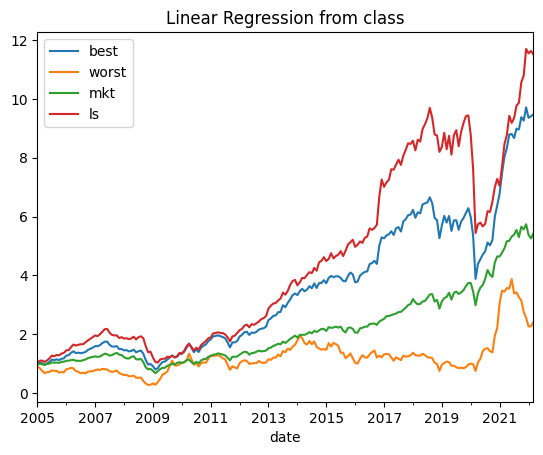

In [131]:
#original first backtest from class
(1+rets_org[["best", "worst", "mkt", "ls"]]).cumprod().plot()
plt.title("Linear Regression from class")

Text(0.5, 1.0, 'Ridge Regression')

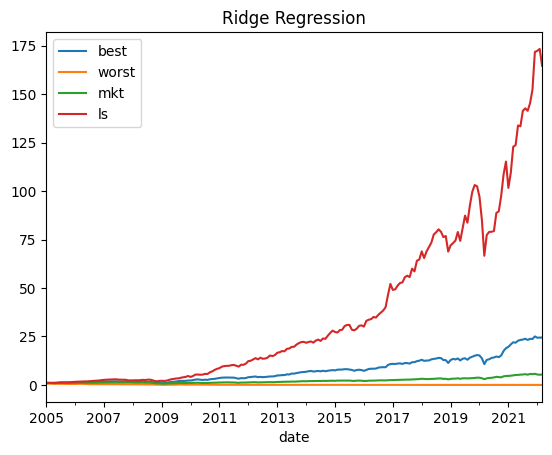

In [132]:
#Ridge backtest
(1+rets[["best", "worst", "mkt", "ls"]]).cumprod().plot()
plt.title("Ridge Regression")

Text(0.5, 1.0, 'Ridge Regression')

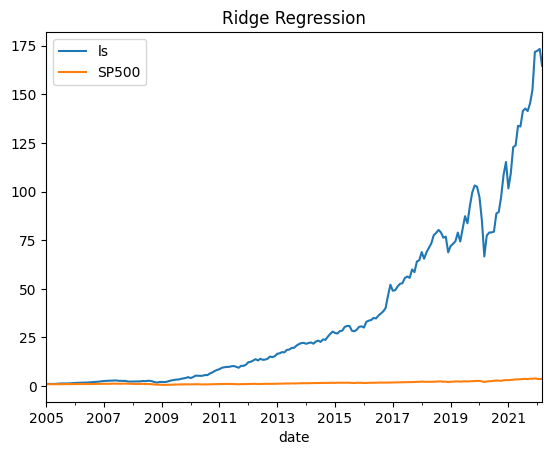

In [133]:
#Ridge backtest
(1+rets[["ls", "SP500"]]).cumprod().plot()
plt.title("Ridge Regression - Long short vs SP500")

#### Ridge Regression - Mean

In [134]:
print(12*rets[["best", "worst", "mkt", "SP500", "ls"]].mean())

best     0.206174
worst   -0.171677
mkt      0.109803
SP500    0.087457
ls       0.319530
dtype: float64


#### Ridge Regression - Risk

In [135]:
print(np.sqrt(12)*rets[["best", "worst", "mkt", "SP500", "ls"]].std())

best     0.196827
worst    0.479095
mkt      0.150797
SP500    0.146056
ls       0.200184
dtype: float64


#### Ridge Regression - Sharpe Ratio

In [137]:
np.sqrt(12)*xrets[["best", "worst", "mkt", "SP500", "ls"]].mean()/xrets[["best", "worst", "mkt", "SP500", "ls"]].std()

best     0.987219
worst   -0.381737
mkt      0.651299
SP500    0.519835
ls       1.535727
dtype: float64

### 130/30 drawdowns

Text(0.5, 1.0, 'Long short')

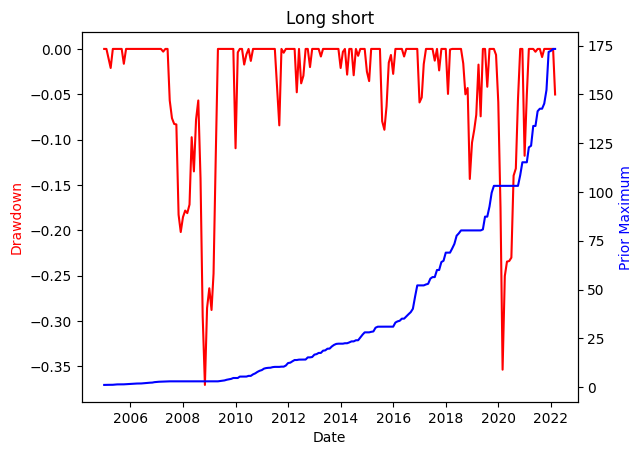

In [141]:
ls = (1+rets.ls).cumprod()
lsmax = ls.expanding().max()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(rets.index.to_timestamp(), lsmax, 'b-')
ax1.plot(rets.index.to_timestamp(), ls/lsmax - 1, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Prior Maximum', color='b')
ax1.set_ylabel('Drawdown', color='r')
plt.title('Long short')

Text(0.5, 1.0, 'SP500')

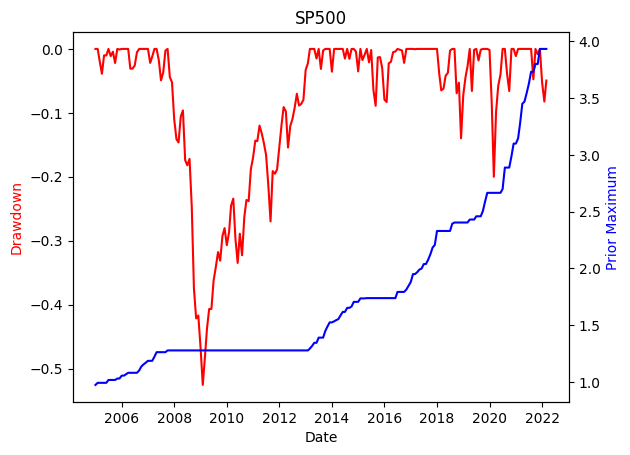

In [143]:
sp500_val = (1+rets.SP500).cumprod()
sp500_valmax = sp500_val.expanding().max()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.plot(rets.index.to_timestamp(), sp500_valmax, 'b-')
ax1.plot(rets.index.to_timestamp(), sp500_val/sp500_valmax - 1, 'r-')

ax1.set_xlabel('Date')
ax2.set_ylabel('Prior Maximum', color='b')
ax1.set_ylabel('Drawdown', color='r')
plt.title("SP500")

In [155]:
tables = []
coefs = []
actives = []

for string in ["best~mkt", "worst~mkt", "SP500~mkt", "ls~mkt"]:
    result2 = smf.ols(string, data=xrets).fit()
    tables.append(result2.summary().tables[1])
    coefs.append(result2.params)
    actives.append(result2.params["Intercept"] + result2.resid)

In [156]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0073      0.002      3.288      0.001       0.003       0.012
mkt            1.0922      0.050     21.876      0.000       0.994       1.191
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0298      0.008     -3.665      0.000      -0.046      -0.014
mkt            1.7736      0.184      9.665      0.000       1.412       2.135
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0016      0.000     -5.093      0.000      -0.002      -0.001
mkt            0.9635      0.007    139.142      0.000       0.950       0.977
                 coef    std err          t      P>|

In [157]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "SP500", "ls"]
np.sqrt(12) * actives.std()

best     0.108093
worst    0.397322
SP500    0.014993
ls       0.149194
dtype: float64

In [158]:
info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     0.807591
worst   -0.900204
SP500   -1.250905
ls       1.479848
dtype: float64

### 130/30 breakdown into market and active returns

Text(0.5, 1.0, 'Ridge Regression')

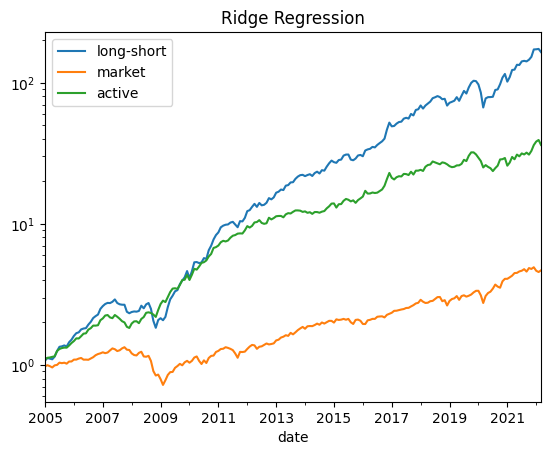

In [148]:
logy = True

beta = coefs[-1]["mkt"]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1+ rets.rf + beta*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()
plt.title("Ridge Regression")

In [149]:
xrets[["smb", "hml", "rmw", "cma"]] = ff[["SMB", "HML", "RMW", "CMA"]]

### Fama-French Benchmark

In [159]:
tables = []
coefs = []
actives = []

strings = [x+"~mkt+smb+hml+rmw+cma" for x in ["best", "worst", "SP500", "ls"]]
for string in strings:
    result3 = smf.ols(string, data=xrets).fit()
    tables.append(result3.summary().tables[1])
    coefs.append(result3.params)
    actives.append(result3.params["Intercept"] + result3.resid)

In [160]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0089      0.002      4.940      0.000       0.005       0.012
mkt            0.9005      0.044     20.257      0.000       0.813       0.988
smb            0.6595      0.079      8.320      0.000       0.503       0.816
hml            0.2760      0.071      3.901      0.000       0.136       0.415
rmw            0.0049      0.104      0.047      0.962      -0.201       0.210
cma            0.0478      0.127      0.377      0.707      -0.202       0.298
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0200      0.008     -2.636      0.009      -0.035      -0.005
mkt            1.3917      0.188      7.404      0.000       1.021       1.762
smb            0.8597      0.335      2.565      0.0

In [161]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "SP500", "ls"]
np.sqrt(12) * actives.std()

best     0.083969
worst    0.355084
SP500    0.007911
ls       0.131256
dtype: float64

In [162]:
info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     1.267630
worst   -0.676529
SP500   -3.007030
ls       1.603293
dtype: float64

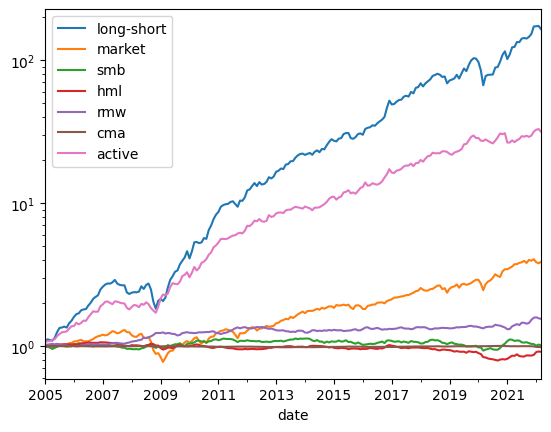

In [163]:
logy = True

betas = coefs[-1]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1 + rets.rf + betas["mkt"]*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1 + betas["smb"]*xrets.smb).cumprod().plot(label="smb", logy=logy)
(1 + betas["hml"]*xrets.hml).cumprod().plot(label="hml", logy=logy)
(1 + betas["rmw"]*xrets.rmw).cumprod().plot(label="rmw", logy=logy)
(1 + betas["cma"]*xrets.cma).cumprod().plot(label="cma", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()